
## About this project

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import time
import random
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.inmoclick_clean_utils import (fix_clean_total_area,
                                  fix_clean_floor_area,
                                  str_serie_to_vector,
                                  vectors_sparse_similarity,
                                  are_similar_properties)

# 1.0- Loading Data

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
houses = pd.read_csv("data_source/dataframe_house.csv")
apartments = pd.read_csv("data_source/dataframe_apartment.csv")
lands = pd.read_csv("data_source/dataframe_land.csv")

In [7]:
fil = houses[houses.district=="Lujan de Cuyo"]
fil = fil[fil.bedrooms=='3']
fil = fil[fil.totalArea=='disable']
fil = fil[fil.bathrooms=='2']
fil.url[:3].values

array(['/52708-remax-chacras/inmuebles/564/ficha/casa-en-venta-en-los-peralitos?btid=3419445',
       '/52708-remax-chacras/inmuebles/574/ficha/casa-en-venta-en-barrio-parque-drummond?btid=3419445',
       '/17515-remax-solutions/inmuebles/1805/ficha/casa-en-venta-en-gobernador-ortiz?btid=3419445'],
      dtype=object)

## 2- Getting duplicated houses

### 2.1- Cleaning and filtering data

In [8]:
print(f'Quantity before cleaning: {len(houses)}')
houses = fix_clean_total_area(houses)
houses = fix_clean_floor_area(houses)
print(f'Quantity after cleaning: {len(houses)}')

Quantity before cleaning: 3456
Quantity after cleaning: 3065


### 2.2- Looking for similar neighborhoods

In [9]:
vectorized_neighborhoods = str_serie_to_vector(houses.neighborhood)
neighborhoods_similarity = vectors_sparse_similarity(vectorized_neighborhoods, vectorized_neighborhoods)
similarity_threshold =  0.5
idx,jdx = np.where(neighborhoods_similarity >= similarity_threshold)
total_comparisons = neighborhoods_similarity.shape[0]*neighborhoods_similarity.shape[1]
print(f'Positive neighborhoods comparisons(similarity upper to {similarity_threshold}): {len(idx)} of {total_comparisons}')

Positive neighborhoods comparisons(similarity upper to 0.5): 50517 of 9394225


### 2.3- Looking for similar properties

In [10]:
similar_houses = []    
for i,j in zip(idx,jdx):
    iprop = houses.iloc[i]
    jprop = houses.iloc[j]
    if i!=j and are_similar_properties(iprop,jprop):
        similar_houses.append([iprop.ref_id,iprop.url,jprop.ref_id,jprop.url,neighborhoods_similarity[i,j]])
similar_houses_df = pd.DataFrame(similar_houses,columns=['ref_id1','url1','ref_id2','url2','cosine_sim'])

# Creating a single list with posible duplicateds
houses_with_similarities = pd.concat([similar_houses_df.ref_id1, similar_houses_df.ref_id2]).unique()
print(f'Quantity of houses with similarities: {len(houses_with_similarities)}')

similar_houses_df.head(3)

Quantity of houses with similarities: 282


,ref_id1,url1,ref_id2,url2,cosine_sim
0,inmueble-2233-336,/2233-fernandez-aubone/inmuebles/336/ficha/cas...,inmueble-438-3139,/438-de-lucia/inmuebles/3139/ficha/casa-en-ven...,0.834395
1,inmueble-2233-336,/2233-fernandez-aubone/inmuebles/336/ficha/cas...,inmueble-1488-250,/1488-fabuel-y-asociados/inmuebles/250/ficha/c...,0.834395
2,inmueble-2233-336,/2233-fernandez-aubone/inmuebles/336/ficha/cas...,inmueble-18229-255,/18229-banco-inmobiliario/inmuebles/255/ficha/...,0.834395


### 2.4*- Showing the greatest similarity quantities

In [11]:
top_similiarities = similar_houses_df.groupby(['ref_id1']).count().ref_id2.to_frame().reset_index()
top_similiarities.columns = ['ref_id','duplicated_qty']
top_similiarities = top_similiarities.sort_values("duplicated_qty",ascending=False)
top_similiarities.head(3)

,ref_id,duplicated_qty
240,inmueble-682-3664,4
54,inmueble-17636-1599,3
94,inmueble-2651-165,3


## 3.0- Analyzing agencies with duplicateds houses

### 3.1- Adding a mark "is_duplicated" to the properties

In [12]:
simil_df = pd.DataFrame(houses_with_similarities,columns=['ref_id'])
simil_df['is_duplicated'] = 1
simil_df.to_csv("duplicated_houses.csv")
# extended_houses
ext_houses = houses.merge(simil_df, left_on='ref_id', right_on='ref_id',how='left')
ext_houses.head(2)

,ref_id,neighborhood,district,province,price,currency,amount,url,description,totalArea,bedrooms,bathrooms,floorArea,agency,property_type,source_web,scrapped_date,totalArea_fixed,floorArea_fixed,is_duplicated
0,inmueble-2233-336,Club de Campo Mendoza,Guaymallen,Mendoza,US$ 410.000,US$,410000.0,/2233-fernandez-aubone/inmuebles/336/ficha/cas...,Inmobiliaria FERNANDEZ AUBONE Vende propiedad ...,400,3,3,268,Fernandez Aubone,PropertyType.HOUSE,inmoclick,2020-07-18,400.0,268.0,1.0
1,inmueble-2229-597,Barrio Cementista II,Las Heras,Mendoza,US$ 155.000,US$,155000.0,/2229-poblete-inmobiliaria/inmuebles/597/ficha...,Moderna Casa de dos plantas.\nFinos detalles y...,220,4,2,190,Poblete Inmobiliaria,PropertyType.HOUSE,inmoclick,2020-07-18,220.0,190.0,NaN


### 3.2- Showing top agencies with duplicated properties

Agencies:74
Duplicated properties:282


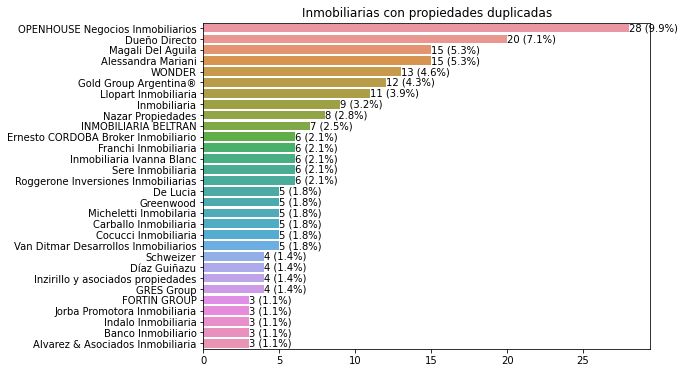

In [13]:
agency = ext_houses[ext_houses.is_duplicated==1].groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("Agencies:"+str(len(agency)))
print("Duplicated properties:"+str(len(ext_houses[ext_houses.is_duplicated==1])))

agency = agency.head(30)
plt.figure(figsize=(8,6))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Inmobiliarias con propiedades duplicadas')
plt.show()